#### Load packages

In [317]:
import random
import numpy as np
import pandas as pd
import networkx as nx
import scipy.stats
import matplotlib.pyplot as plt
import ast

### First Phase (5 agents, 3 balls fixed)

#### Perfect communication model in BSM

In [2]:
class Agent():
    def __init__(self, model, id, reliability):
        self.model = model
        self.id = id
        self.r = reliability
        self.peers = [] # list of all scientists
        self.urn = np.array([]) # probability [nature, agent 1, agent 2,...]
        self.belief = 0 # current belief
        self.choice = None
        self.n_success = 0
    def choose(self):
        prob = self.urn/sum(self.urn)
        return np.random.choice(len(self.urn), size=1, p=prob)[0]
    def experiment(self):
        return 1 if random.random() < self.r else 0
    def update(self):
        self.choice = int(self.choose())
        if self.choice == 0:
            self.belief = self.experiment()
        else:
            self.belief = self.peers[self.choice - 1].belief
        self.n_success += self.belief
    def reinforce(self):
        if self.belief:
            self.urn[self.choice] += 1

In [3]:
class Model():
    def __init__(self, n=5, round_per_gen=100, gen_per_run=200):
        """n: total number of agents"""
        self.n = n
        self.round_per_gen = round_per_gen
        self.gen_per_run = gen_per_run
        self.agents = [] # list of agents
        self.Rs = [round(random.random(), 2) for i in range(n)] # varying reliability
        """Create agents"""
        for i in range(n):
            self.agents.append(Agent(self, i, self.Rs[i]))
        self.init_agents()
    def init_agents(self):
        for a in self.agents:
            a.peers = self.agents
            a.urn = np.array([1] * (self.n + 1))
            a.urn[a.id+1] = 0
    def play(self):
        ls = list(range(self.n))
        random.shuffle(ls)
        for i in ls:
            a = self.agents[i]
            a.update()
            a.reinforce()
    def run(self):
        for i in range(self.gen_per_run):
            for a in self.agents:
                a.belief = a.experiment()
            for i in range(self.round_per_gen):
                self.play()

#### Draw network

In [32]:
def create_network(model, threshold):    
    
    # Create a directed graph with significant edges (above threshold prob)
    G = nx.DiGraph()
    G.add_node('nature')
    for a in model.agents:
        G.add_node(a.id)
        if a.urn[0]/sum(a.urn) > threshold:
            G.add_edge(a.id, "nature", weight=a.urn[0]/sum(a.urn))
        for i in range(model.n):
            if (a.id != i) and (a.urn[i+1]/sum(a.urn) > threshold):
                G.add_edge(a.id, i, weight=a.urn[i+1]/sum(a.urn))
    return(G)

In [31]:
def plot_network(model, G, threshold=0.3):

    # G = create_network(model, threshold)
    # Get the weights for the edges
    weights = nx.get_edge_attributes(G, 'weight')
    
    # Normalize weights for better visualization
    max_weight = max(weights.values(), default=1)
    edge_widths = [(weight * 2) / max_weight for weight in weights.values()]
    
    # Draw the network
    pos = nx.shell_layout(G)
    nx.draw(G, pos, with_labels=False, node_color='lightblue', node_size=1500, 
            arrows=True, arrowstyle='-|>', arrowsize=20, edge_color='black', 
            width=edge_widths, edgecolors='black')

    # Label with reliability
    labels = {key: value for key, value in zip(range(model.n), model.Rs)}
    labels['nature'] = 'nature'
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10)

    # Label edges
    edge_labels = {(u, v): f'{d["weight"]:.2f}' for u, v, d in G.edges(data=True)}

    for (u, v), label in edge_labels.items():
        # Compute midpoint
        x_start, y_start = pos[u]
        x_end, y_end = pos[v]
        
        # Offset to position label closer to the start of the edge
        offset = 0.6  # Adjust this value to control the distance from the start
        x_label = x_start + offset * (x_end - x_start)
        y_label = y_start + offset * (y_end - y_start)
        
        # Draw the label
        plt.text(x_label, y_label, label, color='black', fontsize=10, 
                 ha='center', va='center',
                 bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3')
                )

#### Test Model Code

In [32]:
df = pd.DataFrame(columns=['reliability', 'matrix', 'success'])
for i in range(1):
    m = Model(n=5)
    m.run()
    df.loc[i] = [m.Rs, [a.urn for a in m.agents], [a.n_success for a in m.agents]]

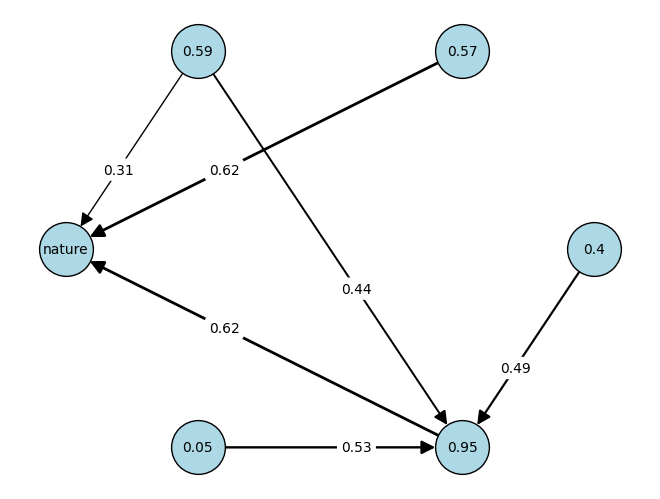

In [33]:
plot_network(m)

In [34]:
df

,reliability,matrix,success
0,"[0.05, 0.95, 0.4, 0.57, 0.59]","[[475, 0, 8274, 3913, 136, 2753], [11427, 3251...","[18777, 19197, 18740, 15742, 17911]"


#### BH Model (My Version)

In [6]:
class BHAgent(Agent):
    def __init__(self, model, id, reliability, n_votes=3):
        super().__init__(model, id, reliability)
        self.n_votes = n_votes
    def choose(self):
        choice = np.array([0]*len(self.urn)) # Array recording balls drawn
        for i in range(self.n_votes):
            prob = self.urn/sum(self.urn) # Prob proportionate to num of balls
            pick = np.random.choice(range(len(self.urn)), p=prob)
            choice[pick] += 1
            self.urn[pick] -= 1
        self.urn = self.urn + choice # Return balls back to urn
        return choice
    def update(self):
        self.choice = self.choose()
        votes = 0
        for i in range(self.choice[0]):
            votes += self.experiment()
        votes += sum(self.choice[1:] * np.array([a.belief for a in self.model.agents]))
        if votes > (sum(self.choice) * 0.5):
            self.belief = 1
        else:
            self.belief = 0
        self.n_success += self.belief
    def reinforce(self):
        if self.belief:
            self.urn = self.urn + self.choice

In [7]:
class BHModel(Model):
    def __init__(self, n=5, round_per_gen=100, gen_per_run=200):
        """n: total number of agents"""
        super().__init__(n, round_per_gen, gen_per_run)
        self.agents = []
        for i in range(n):
            self.agents.append(BHAgent(self, i, self.Rs[i]))
        self.init_agents()

#### Add Group Reward (Consensus) to BH Model

In [8]:
class CoopWeightAgent(BHAgent):
    "Strength of reinforcement dependent on success of group"
    "Only reinforce if there is individual success"
    def __init__(self, model, id, reliability, n_votes=3, w=1):
        super().__init__(model, id, reliability, n_votes)
        self.w = w # weight
    def reinforce(self, s):
        if self.belief:
            self.urn = self.urn + self.choice * self.w * s

In [9]:
class CoopBonusAgent(BHAgent):
    "First reinforce based on individual results"
    "BONUS reinforcement dependent on success of group"
    def __init__(self, model, id, reliability, n_votes=3, w=1):
        super().__init__(model, id, reliability, n_votes)
        self.w = w # weight
    def reinforce(self, s):
        if self.belief:
            self.urn = self.urn + self.choice
        self.urn = self.urn + self.choice * self.w * s

In [10]:
class CoopRewardModel(BHModel):
    def __init__(self, n=5, round_per_gen=100, gen_per_run=200, weight=1, v=1):
        super().__init__(n, round_per_gen, gen_per_run)
        self.w = weight
        self.agents = []
        if v == 1:
            for i in range(n):
                self.agents.append(CoopWeightAgent(self, i, self.Rs[i]))
        elif v == 2:
            for i in range(n):
                self.agents.append(CoopBonusAgent(self, i, self.Rs[i]))
        self.init_agents()
    def play(self):
        ls = list(range(self.n))
        random.shuffle(ls)
        for i in ls:
            a = self.agents[i]
            a.update()
        s = sum([a.belief for a in self.agents]) # Number of successful agents this round
        for a in self.agents:
            a.reinforce(s)

#### Add Competition to BH Model

In [11]:
class CompetitionModel(BHModel):
    def __init__(self, n=5, round_per_gen=100, gen_per_run=200, weight=1, v=1):
        super().__init__(n, round_per_gen, gen_per_run)
        self.w = weight
        self.agents = []
        if v == 1:
            for i in range(n):
                self.agents.append(CoopWeightAgent(self, i, self.Rs[i]))
        elif v == 2:
            for i in range(n):
                self.agents.append(CoopBonusAgent(self, i, self.Rs[i]))
        self.init_agents()
    def play(self):
        ls = list(range(self.n))
        random.shuffle(ls)
        for i in ls:
            a = self.agents[i]
            a.update()
        s = self.n - sum([a.belief for a in self.agents]) # Number of unsuccessful agents this round
        for a in self.agents:
            a.reinforce(s)

#### Compare Binary Models

In [54]:
columns = ['reliability', 
           'matrix_BSM', 'success_BSM',
           'matrix_BH', 'success_BH', 
           'matrix_GC2_F', 'success_GC2_F',
           'matrix_comp2_F', 'success_comp2_F'
          ]
df = pd.DataFrame(columns=columns)
n = 5

Rs = pd.read_csv('Rs.csv')
Rs = Rs['reliability'].apply(ast.literal_eval)

for i in range(1):
    models = [Model(n=n),
              BHModel(n=n),
              CoopRewardModel(n=n, weight=1, v=2), 
              CompetitionModel(n=n, weight=1, v=2)]
    for m in models:
        for a in m.agents:
            a.r = Rs[i][a.id]
    data = []
    data.append(Rs[i])
    for m in models:
        m.run()
        data.append([a.urn for a in m.agents])
        data.append([a.n_success for a in m.agents])
    df = pd.concat([df, pd.DataFrame([data], columns=columns)], ignore_index=True)

In [55]:
df

,reliability,matrix_BSM,success_BSM,matrix_BH,success_BH,matrix_GC2_F,success_GC2_F,matrix_comp2_F,success_comp2_F
0,"[0.69, 0.78, 0.62, 0.07, 0.99]","[[222, 0, 14680, 1245, 1786, 680], [2732, 708,...","[18608, 18676, 18739, 18763, 19601]","[[7871, 0, 5949, 4533, 3792, 30570], [15403, 8...","[17570, 17661, 17523, 17499, 17626]","[[408, 0, 132281, 100034, 79589, 18002], [193,...","[18283, 18354, 18208, 18326, 18649]","[[81522, 0, 72691, 5849, 27602, 44526], [49630...","[8031, 6574, 5713, 4460, 5858]"


#### Test Baseline

In [14]:
columns = ['matrix_BH', 'success_BH', 
           'matrix_CoopWeight', 'success_CoopWeight', 
           'matrix_CompWeight', 'success_CompWeight']
df = pd.DataFrame(columns=columns)
n = 5

for i in range(1):
    models = [BHModel(n=n), 
              CoopRewardModel(n=n, weight=1, v=1),
              CompetitionModel(n=n, weight=1, v=1)]
    for m in models:
        for a in m.agents:
            a.r = 0.5
    data = []
    for m in models:
        m.run()
        data.append([a.urn for a in m.agents])
        data.append([a.n_success for a in m.agents])
    df = pd.concat([df, pd.DataFrame([data], columns=columns)], ignore_index=True)

df

,matrix_BH,success_BH,matrix_CoopWeight,success_CoopWeight,matrix_CompWeight,success_CompWeight
0,"[[8573, 0, 2718, 6422, 7388, 4904], [5590, 108...","[10000, 10018, 10041, 10035, 9958]","[[58020, 0, 15442, 1671, 3598, 34524], [69320,...","[9928, 9833, 9890, 9883, 9936]","[[5526, 0, 17899, 2745, 842, 13646], [14372, 1...","[10002, 10074, 10064, 10005, 10048]"


### Generalized Model (More agents, flexible number of balls)

#### Flexible model with individual reward

In [128]:
class flexAgent(Agent):
    
    def __init__(self, model, id, reliability, prior=5):
        super().__init__(model, id, reliability)
        self.prior = prior
        self.votes = []
        
    def choose(self):
        choice = np.array([0]*len(self.urn)) # Array recording selection
        for i in range(len(choice)):
            prob = self.urn[i][0]/sum(self.urn[i]) # Prob proportionate to num of balls
            if random.random() < prob:
                choice[i] += 1
        return choice
        
    def update(self):
        self.choice = self.choose()
        self.votes = self.choice * (np.concatenate([np.array([self.experiment()]), 
                                               np.array([a.belief for a in self.model.agents])]))
        if sum(self.votes) > (sum(self.choice) * 0.5):
            self.belief = 1
        else:
            self.belief = 0
        self.n_success += self.belief

    def reinforce(self):
        for i in range(len(self.choice)):
            if self.choice[i]:
                if self.votes[i]:
                    self.urn[i][0] += 1
                else:
                    self.urn[i][1] += 1
        self.urn[self.id+1] = [0, 1]

In [129]:
class flexModel(Model):
    def __init__(self, n=5, round_per_gen=100, gen_per_run=200, prior=5):
        """n: total number of agents"""
        self.n = n
        self.round_per_gen = round_per_gen
        self.gen_per_run = gen_per_run
        self.agents = [] # list of agents
        self.Rs = [round(random.random(), 2) for i in range(n)] # varying reliability
        self.prior = prior
        for i in range(n):
            self.agents.append(flexAgent(self, i, self.Rs[i], prior))
        self.init_agents()
    def init_agents(self):
        for a in self.agents:
            a.peers = self.agents
            a.urn = np.full((self.n + 1, 2), a.prior)
            a.urn[a.id+1] = [0, 1] # agents do not draw themselves

#### Test flexible model

In [130]:
def create_network_flex(model, threshold=0.5):    
    
    # Create a directed graph with significant edges (above threshold prob)
    G = nx.DiGraph()
    G.add_node('nature')
    for a in model.agents:
        G.add_node(a.id)
        if a.urn[0][0]/sum(a.urn[0]) > threshold:
            G.add_edge(a.id, "nature", weight=a.urn[0][0]/sum(a.urn[0]))
        for i in range(model.n):
            if (a.id != i) and (a.urn[i+1][0]/sum(a.urn[i+1]) > threshold):
                G.add_edge(a.id, i, weight=a.urn[i+1][0]/sum(a.urn[i+1]))
    return(G)

In [134]:
df = pd.DataFrame(columns=['reliability', 'matrix', 'success'])
for i in range(1):
    m = flexModel(n=5, prior=5)
    m.run()
    df.loc[i] = [m.Rs, [[round(u[0]/sum(u), 2) for u in a.urn] for a in m.agents], [a.n_success for a in m.agents]]

In [135]:
df

,reliability,matrix,success
0,"[0.34, 0.34, 0.14, 0.81, 0.85]","[[0.35, 0.0, 0.22, 0.22, 0.39, 0.42], [0.34, 0...","[4532, 4457, 4247, 7805, 8191]"


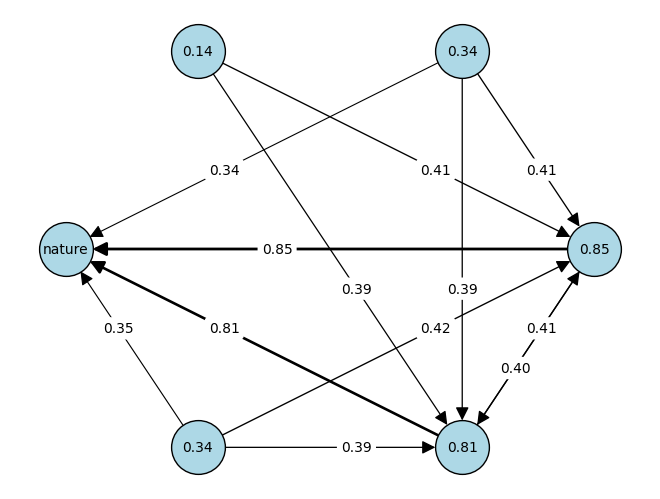

In [137]:
plot_network(m, create_network_flex(m, threshold=0.3))

#### Add group rewards

In [282]:
class flexWeightAgent(flexAgent):
    "Strength of reinforcement dependent on success of group"
    "Only reinforce if there is individual success"
    def __init__(self, model, id, reliability, prior=5, w=1):
        super().__init__(model, id, reliability, prior)
        self.w = w # weight
    def reinforce(self, s):
        for i in range(len(self.choice)):
            if self.choice[i]:
                if self.votes[i]:
                    self.urn[i][0] += s * self.w
                else:
                    self.urn[i][1] += s * self.w
        self.urn[self.id+1] = [0, 1]

In [283]:
class flexCoopModel(flexModel):
    def __init__(self, n=5, round_per_gen=100, gen_per_run=200, prior=5, w=1):
        super().__init__(n, round_per_gen, gen_per_run, prior)
        self.w = w
        self.agents = []
        for i in range(n):
            self.agents.append(flexWeightAgent(self, i, self.Rs[i], prior, w))
        self.init_agents()
    def play(self):
        ls = list(range(self.n))
        random.shuffle(ls)
        for i in ls:
            a = self.agents[i]
            a.update()
        s = sum([a.belief for a in self.agents]) # Number of unsuccessful agents this round

        for a in self.agents:
            a.reinforce(s)

In [284]:
class flexCompModel(flexModel):
    def __init__(self, n=5, round_per_gen=100, gen_per_run=200, prior=5, w=1):
        super().__init__(n, round_per_gen, gen_per_run, prior)
        self.w = w
        self.agents = []
        for i in range(n):
            self.agents.append(flexWeightAgent(self, i, self.Rs[i], prior, w))
        self.init_agents()
    def play(self):
        ls = list(range(self.n))
        random.shuffle(ls)
        for i in ls:
            a = self.agents[i]
            a.update()
        s = self.n - sum([a.belief for a in self.agents]) # Number of unsuccessful agents this round
        
        for a in self.agents:
            a.reinforce(s)

#### Test flexible model with group rewards

In [301]:
df = pd.DataFrame(columns=['reliability', 'matrix', 'success'])
for i in range(1):
    m = flexCompModel(n=7, prior=30, w=1)
    m.run()
    df.loc[i] = [m.Rs, [[round(u[0]/sum(u), 2) for u in a.urn] for a in m.agents], [a.n_success for a in m.agents]]

In [302]:
df

,reliability,matrix,success
0,"[0.28, 0.24, 0.95, 0.84, 0.63, 0.03, 0.91]","[[0.26, 0.0, 0.14, 0.36, 0.28, 0.22, 0.15, 0.3...","[6548, 6529, 11396, 9808, 8041, 6787, 10668]"


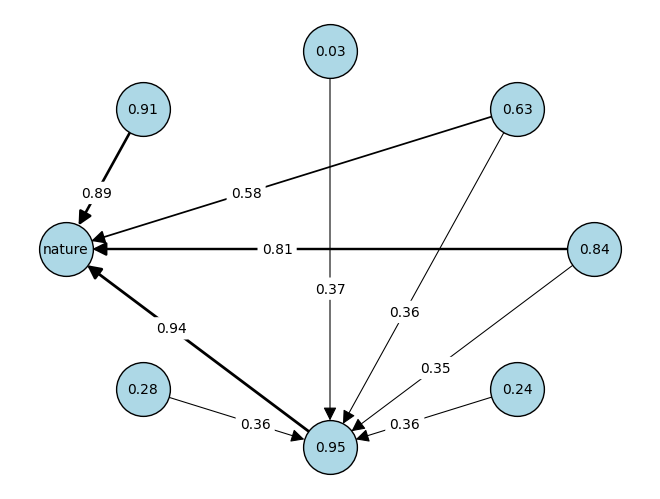

In [304]:
plot_network(m, create_network_flex(m, threshold=0.35))

#### Comparisons

In [315]:
columns = ['reliability', 
           'matrix_flex', 'success_flex',
           'matrix_flexCoop_F', 'success_flexCoop_F',
           'matrix_flexComp_F', 'success_flexComp_F'
          ]
df = pd.DataFrame(columns=columns)
n = 7
prior = 10
w = 1

for i in range(1):
    models = [flexModel(n=n, prior=prior),
              flexCoopModel(n=n, prior=prior, w=w),
              flexCompModel(n=n, prior=prior, w=w)]

    data = []
    data.append([a.r for a in m.agents])
    for m in models:
        m.run()
        data.append([[round(u[0]/sum(u), 2) for u in a.urn] for a in m.agents])
        data.append([a.n_success for a in m.agents])
    df = pd.concat([df, pd.DataFrame([data], columns=columns)], ignore_index=True)

In [316]:
df

,reliability,matrix_flex,success_flex,matrix_flexCoop_F,success_flexCoop_F,matrix_flexComp_F,success_flexComp_F
0,"[0.18, 0.12, 0.42, 0.32, 0.44, 0.52, 0.12]","[[0.83, 0.0, 0.3, 0.43, 0.38, 0.42, 0.31, 0.31...","[7705, 6196, 8577, 7529, 8154, 6195, 6313]","[[0.15, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0...","[5617, 5617, 5624, 5622, 5622, 5640, 5631]","[[0.84, 0.0, 0.26, 0.16, 0.19, 0.14, 0.17, 0.2...","[8844, 8342, 5889, 6774, 5031, 6117, 8048]"
